In [20]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from material_models import GOH_fullyinc
from misc import preprocessing, normalization, predict
import tensorflow as tf
import pickle
import pandas as pd
import tensorflow.keras.backend as K

## Generate line plot data

In [26]:
GOH_params

[[0.0, 6.66375239, 2.10007379, 0.32194361, 1.57089277],
 [0.0, 5.56814876, 2.17702876, 0.28625754, 1.57090147],
 [0.0, 6.45220922, 2.24243604, 0.31306001, 1.57132957],
 [0.0, 5.28151486, 2.0823615, 0.2881214, 1.57106945],
 [0.0, 5.40692214, 1.58278121, 0.30029796, 1.57079144]]

In [30]:
data = 'P12BC2_xybsxsy'
theta = 0
models = ['P12BC2_xy', 'P12BC2_sxsy', 'P12BC2_xyb', 'P12BC2_bsxsy', 'P12BC2_xysxsy']
lim = [0, 76, 76+76, 76+76+95, 76+76+95+101, 76+76+95+101+84]
GOH_params = [[0.,         6.66375239, 2.10007379, 0.32194361, 1.57089277],
              [0.,         5.56814876, 2.17702876, 0.28625754, 1.57090147],
              [0.,         6.45220922, 2.24243604, 0.31306001, 1.57132957],
              [0.,         5.28151486, 2.0823615 , 0.2881214 , 1.57106945],
              [0.,         5.40692214, 1.58278121, 0.30029796, 1.57079144]]
stress_gt = []
stress_pr = []
stress_goh = []
stretches = []
for model, params in zip(models, GOH_params):
    _, _, _, _, _, _, lm, _, sigma_gt, _, _, _  = preprocessing(data, theta1=theta)
    sigma_pr, _, _, _, _, _ = predict(model, data, impose_convexity=True, theta1=theta)
    GOH = GOH_fullyinc(lm, *params)
    sigma_GOH = GOH.s(lm)
    stress_goh.append(sigma_GOH)
    stress_gt.append(sigma_gt)
    stress_pr.append(sigma_pr)
    stretches.append(lm)

## Calculate Errors

In [33]:
errors_dnn = []
for sigma_pr, sigma_gt in zip(stress_pr, stress_gt):
    error = np.zeros(sigma_gt.shape[0])
    for i in range(sigma_gt.shape[0]):
        for j in range(3):
            for k in range(3):
                error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
        error[i] = np.sqrt(error[i])
    error = error*1000 #MPa -> kPa
    offx_error = np.mean(error[:lim[1]])
    offy_error = np.mean(error[lim[1]:lim[2]])
    equi_error = np.mean(error[lim[2]:lim[3]])
    strx_error = np.mean(error[lim[3]:lim[4]])
    stry_error = np.mean(error[lim[4]:lim[5]])
    errors_dnn.append([offx_error, offy_error, equi_error, strx_error, stry_error])
print('DNN Errors:')
print(errors_dnn)

errors_goh = []
for sigma_pr, sigma_gt in zip(stress_goh, stress_gt):
    error = np.zeros(sigma_gt.shape[0])
    for i in range(sigma_gt.shape[0]):
        for j in range(3):
            for k in range(3):
                error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
        error[i] = np.sqrt(error[i])
    error = error*1000 #MPa -> kPa
    offx_error = np.mean(error[:lim[1]])
    offy_error = np.mean(error[lim[1]:lim[2]])
    equi_error = np.mean(error[lim[2]:lim[3]])
    strx_error = np.mean(error[lim[3]:lim[4]])
    stry_error = np.mean(error[lim[4]:lim[5]])
    errors_goh.append([offx_error, offy_error, equi_error, strx_error, stry_error])
print('GOH Errors:')
print(errors_goh)

DNN Errors:
[[16.637810801822244, 6.567573297034728, 40.403751210588574, 9.806976703924565, 85.9709287019906], [144.18444630237053, 167.72174683446374, 146.21487636793645, 15.994092663800396, 18.674031883553237], [19.51000198588234, 14.796299860146112, 29.530711486860362, 14.419530852901795, 76.54552583920626], [65.17437935134834, 39.2256063518962, 16.72092629613687, 27.71348992879262, 22.196963891253134], [33.3264425366082, 25.025882452838545, 27.23530561142263, 17.5602938974844, 58.68650912875058]]
GOH Errors:
[[28.173436050847457, 22.94394023396969, 46.487585186696414, 19.098964106470316, 69.410610438232], [92.50431800933804, 58.47014955342717, 49.4124820865136, 24.0847050289687, 47.2883674792486], [37.77524868343982, 26.163702190568795, 40.71891656011906, 19.791235049264326, 57.729550465233515], [78.27556376295259, 50.43808062468862, 42.954950097905126, 22.054723637409364, 46.91723186463386], [47.87839361027757, 35.01526547276358, 39.21644196468626, 18.385018011539465, 51.493309425

## Porcine validation figure

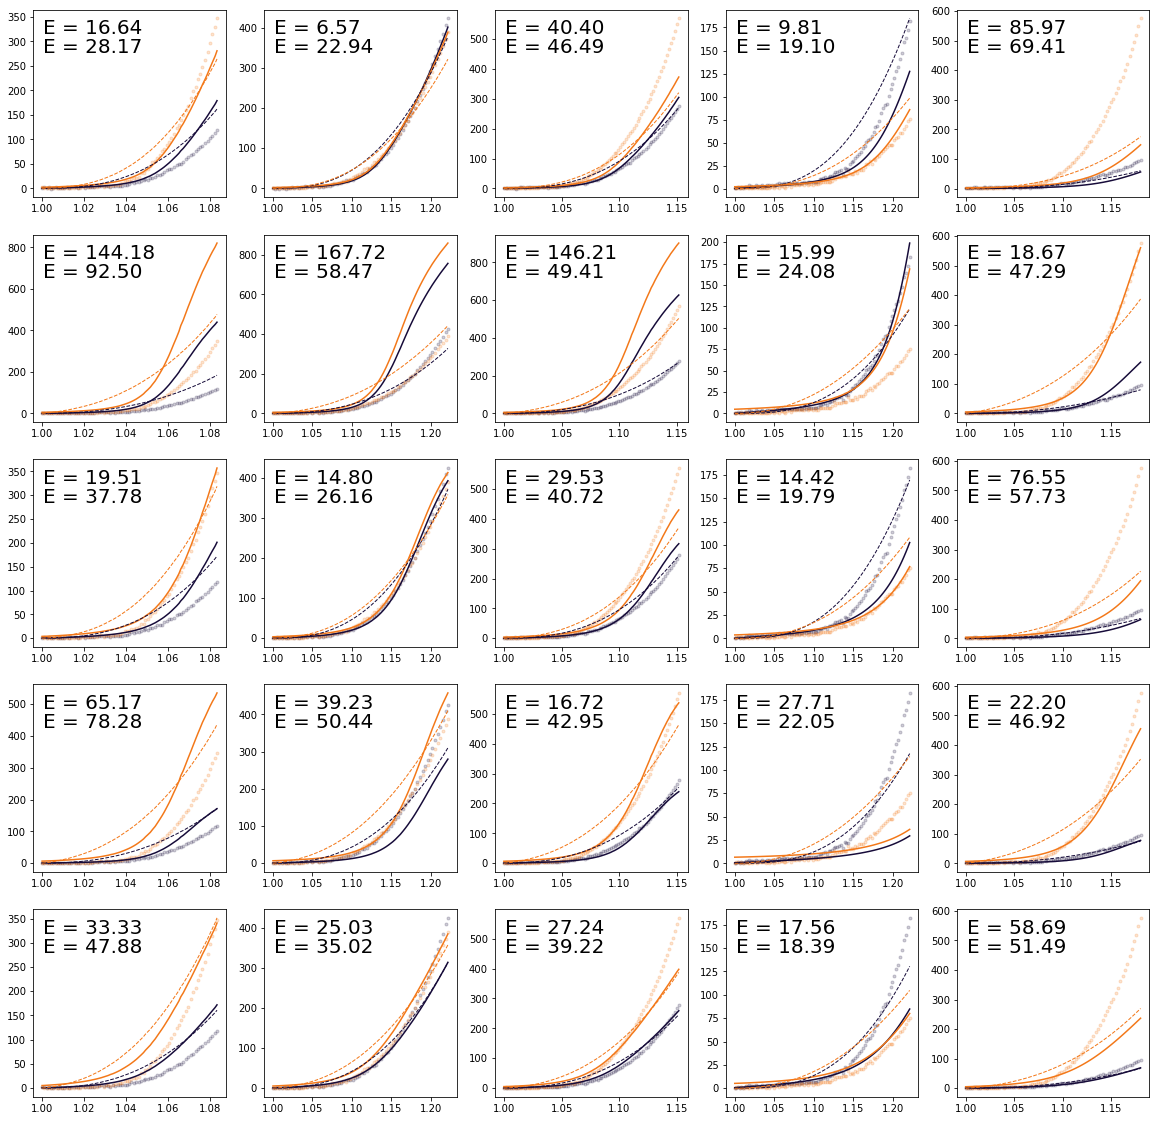

In [34]:
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.1, 0.7, 2)))
pltparams = {'lines.linewidth': 4,}
fig, ax = plt.subplots(5,5,figsize=(20,20))
for i, (model, lm, sigma_pr, sigma_gt, sigma_goh) in enumerate(zip(models, stretches, stress_pr, stress_gt, stress_goh)):
    for j in range(5):
        if j < 4:
            lmx_or_lmy = 0
        else:
            lmx_or_lmy = 1
        i1 = lim[j]
        i2 = lim[j+1]
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_gt[i1:i2,0,0]*1000,'.',alpha=0.2)
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_gt[i1:i2,1,1]*1000,'.',alpha=0.2)
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_pr[i1:i2,0,0]*1000)
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_pr[i1:i2,1,1]*1000)
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_goh[i1:i2,0,0]*1000,'--',linewidth=1)
        ax[i,j].plot(lm[i1:i2,lmx_or_lmy], sigma_goh[i1:i2,1,1]*1000,'--',linewidth=1)
        mystr = 'E = {s:.2f}'.format(s=errors_dnn[i][j])
        ax[i,j].text(0.05,0.95, mystr, transform=ax[i,j].transAxes, va='top', fontsize=20)
        mystr = 'E = {s:.2f}'.format(s=errors_goh[i][j])
        ax[i,j].text(0.05,0.85, mystr, transform=ax[i,j].transAxes, va='top', fontsize=20)
fig.savefig('figs/fig_porcine_val.jpg',bbox_inches='tight')


## Save pgfplots data

#### Line plots data

In [35]:
labels_list = [['A1', 'A2', 'A3', 'A4', 'A5'], 
               ['B1', 'B2', 'B3', 'B4', 'B5'], 
               ['C1', 'C2', 'C3', 'C4', 'C5'], 
               ['D1', 'D2', 'D3', 'D4', 'D5'],
               ['E1', 'E2', 'E3', 'E4', 'E5']]
for labels, lm, sigma_pr, sigma_gt, sigma_goh in zip(labels_list, stretches, stress_pr, stress_gt, stress_goh):
    for i, label in enumerate(labels):
        if i < 4:
            lmx_or_lmy = 0
        else:
            lmx_or_lmy = 1
        i1 = lim[i]
        i2 = lim[i+1]
        x = lm[i1:i2,lmx_or_lmy]
        y_pr_x = sigma_pr[i1:i2,0,0]*1000
        y_pr_y = sigma_pr[i1:i2,1,1]*1000
        y_gt_x = sigma_gt[i1:i2,0,0]*1000
        y_gt_y = sigma_gt[i1:i2,1,1]*1000
        y_goh_x = sigma_goh[i1:i2,0,0]*1000
        y_goh_y = sigma_goh[i1:i2,1,1]*1000
        data = np.stack([x, y_pr_x, y_pr_y, y_gt_x, y_gt_y, y_goh_x, y_goh_y])
        header = ['x', 'prx', 'pry', 'gtx', 'gty', 'gohx', 'gohy']
        df = pd.DataFrame(data.T, columns=header)
        df.to_csv('tikz_data/fig_porcine_val/fig_porcine_val_'+label+'.csv', index=False, sep=' ')